In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from warnings import simplefilter, filterwarnings
filterwarnings("ignore", category=FutureWarning)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

In [147]:
patients = ['001', '002', '004', '006', '007', '008']
features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']

In [148]:
def get_projected_value(window, prediction_horizon):
    x = np.arange(len(window))
    coeffs = np.polyfit(x, window, deg=3)
    poly = np.poly1d(coeffs)
    projected_value = poly(len(window) + prediction_horizon)
    return projected_value


def get_data(patient, food_data, prediction_horizon):
    glucose_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/glucose.csv")
    insulin_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv")

    glucose_data["datetime"] = pd.to_datetime(glucose_data["date"] + ' ' + glucose_data["time"])
    glucose_data.drop(['type', 'comments', 'date', 'time'], axis=1, inplace=True)
    glucose_data['glucose'] *= 18.0182  # Convert to mg/dL

    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data.drop(['comment', 'date', 'time'], axis=1, inplace=True)

    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']]

    combined_data = pd.concat([food_data, insulin_data]).sort_values('datetime').reset_index(drop=True)
    combined_data.fillna(0, inplace=True)
    glucose_data['hour'] = glucose_data['datetime'].dt.hour

    glucose_data['glucose_next'] = glucose_data['glucose'] - glucose_data['glucose'].shift(-prediction_horizon)

    glucose_data['glucose_change'] = glucose_data['glucose'] - glucose_data['glucose'].shift(1)

    glucose_data[f'glucose_change_sh_3'] = glucose_data['glucose_change'].shift(3)

    for window in [2, 3, 6]:
        glucose_data[f'glucose_change_std_{window}'] = glucose_data['glucose_change'].rolling(window=window).std()
    
    delta = glucose_data['glucose'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=6).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=6).mean()
    glucose_data['glucose_rsi'] = 100 - (100 / (1 + gain / loss))

    glucose_data['glucose_change_projected'] = glucose_data['glucose_change'].rolling(
        window=6, min_periods=6
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    glucose_data['glucose_projected'] = glucose_data['glucose'].rolling(
        window=6, min_periods=6
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    glucose_data.dropna(subset=['glucose_next'], inplace=True)
    return glucose_data, combined_data

def calculate_weights(time_diff_hours, metabolism_rate, peak_time):
    weights = np.zeros_like(time_diff_hours)
    increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
    plateau_duration = 0.25
    weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
    plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
    weights[plateau_mask] = 1
    decrease_mask = time_diff_hours >= peak_time + plateau_duration
    weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
    return np.clip(weights, 0, None)


def add_features(params, features, preprocessed_data, prediction_horizon, patient):
    patients_glucose_data = []
    glucose_data, combined_data = preprocessed_data
    
    glucose_times = glucose_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    combined_times = combined_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    for feature in features:
        metabolism_rate, peak_time = params[feature]
        time_diff_hours = ((glucose_times[:, None] - combined_times[None, :]) / 3600)
        weights = np.zeros_like(time_diff_hours)
        increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
        weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
        plateau_duration = 0.25
        plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
        weights[plateau_mask] = 1
        decrease_mask = time_diff_hours >= peak_time + plateau_duration
        weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
        weights = np.clip(weights, 0, None)
        glucose_data[feature] = np.dot(weights, combined_data.loc[:, feature].values)
        glucose_data[feature] = glucose_data[feature] - glucose_data[feature].shift(-prediction_horizon) + glucose_data['glucose_change']

        patients_glucose_data.append(glucose_data)
    patients_glucose_data = pd.concat(patients_glucose_data)
    patients_glucose_data.dropna(inplace=True)
    return patients_glucose_data

In [149]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '001'
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")
features_to_remove = ['glucose_next', 'datetime']
feature_params = {
    'simple_sugars': [0.5, 0.5],  # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.05, 3.5],
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

In [150]:
food_data

,picture,datetime,simple_sugars,complex_sugars,proteins,fats,dietary_fibers,weight,message
0,001.jpg,2014:10:01 19:27:49,0,2,3,1,6,150,Simple sugars (g): 0\nComplex sugars (g): 2\nP...
1,002.jpg,2014:10:01 19:32:00,4,20,25,18,4,250,Simple sugars (g): 4\nComplex sugars (g): 20\n...
2,003.jpg,2014:10:01 19:43:59,0,0,3,8,0,20,- Simple sugars (g): 0\n- Complex sugars (g): ...
3,004.jpg,2014:10:02 10:11:16,15,40,10,15,5,250,Simple sugars (g): 15\nComplex sugars (g): 40\...
4,005.jpg,2014:10:02 19:34:03,10,50,20,15,8,350,Simple sugars (g): 10\nComplex sugars (g): 50\...
5,006.jpg,2014:10:02 19:44:51,5,3,2,1,5,250,Simple sugars (g): 5\nComplex sugars (g): 3\nP...
6,007.jpg,2014:10:03 10:08:48,2,35,6,1,2,80,Simple sugars (g): 2\nComplex sugars (g): 35\n...
7,008.jpg,2014:10:03 12:37:00,5,10,5,3,6,200,Simple sugars (g): 5\nComplex sugars (g): 10\n...
8,009.jpg,2014:10:03 12:59:00,5,50,30,30,5,500,Simple sugars (g): 5\nComplex sugars (g): 50\n...
9,010.jpg,2014:10:03 12:59:04,5,40,10,8,2,100,Simple sugars (g): 5\nComplex sugars (g): 40\n...


In [151]:
def modify_macronutrients(food_data, nutrient, amount):
    """Modify a specific macronutrient by a given amount."""
    modified_food_data = food_data.copy()
    modified_food_data[nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [187]:
# Create DataFrame to store results
results_df = pd.DataFrame(columns=['feature', 'increment', 'hyper_minutes', 'hypo_minutes', 'mean_glucose'])
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50] 
# Simulate additions/subtractions for each feature
for feature in meal_features:
    for increment in increments:
        patient_hyper_times = []
        patient_hypo_times = []
        patient_means = []
        for patient in patients:
            # Load patient model
            model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

            # Get modified predictions
            modified_food_data = modify_macronutrients(food_data, feature, increment)
            data_modified = get_data(patient, modified_food_data, prediction_horizon)
            test_modified = add_features(feature_params, features, data_modified, prediction_horizon, patient)
            X_test_modified = test_modified.drop(features_to_remove, axis=1)
            preds_modified = X_test_modified['glucose'] - model.predict(X_test_modified)

            # Convert predictions to binary indicators and calculate time in minutes
            hyper_binary_preds = (preds_modified >= 180).astype(int)
            hypo_binary_preds = (preds_modified <= 70).astype(int)
            
            hyperglycemia_count = np.sum(hyper_binary_preds)
            hypoglycemia_count = np.sum(hypo_binary_preds)
            
            hyperglycemia_hours = hyperglycemia_count / 12
            hypoglycemia_hours = hypoglycemia_count / 12
            
            patient_hyper_times.append(hyperglycemia_hours)
            patient_hypo_times.append(hypoglycemia_hours)
            patient_means.append(np.mean(preds_modified))

            # Average time and glucose levels across patients
            total_hyper_time = np.mean(patient_hyper_times)
            total_hypo_time = np.mean(patient_hypo_times)
            mean_glucose = np.mean(patient_means)

            # Store in DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'patient': [patient],
                'feature': [feature],
                'increment': [increment],
                'hyper_minutes': [total_hyper_time],
                'hypo_minutes': [total_hypo_time],
                'mean_glucose': [mean_glucose]
            })])

# Pivot the DataFrame for easier calculations
hyper_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='hyper_minutes', aggfunc='mean')
hypo_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='hypo_minutes', aggfunc='mean')
glucose_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='mean_glucose', aggfunc='mean')

# Get the baseline values at increment = 0
hyper_baseline = hyper_pivot_df.loc[0]
hypo_baseline = hypo_pivot_df.loc[0]
glucose_baseline = glucose_pivot_df.loc[0]

# Calculate the difference from the baseline
hyper_difference_df = hyper_pivot_df.subtract(hyper_baseline, axis='columns').reset_index()
hypo_difference_df = hypo_pivot_df.subtract(hypo_baseline, axis='columns').reset_index()
glucose_difference_df = glucose_pivot_df.subtract(glucose_baseline, axis='columns').reset_index()

In [195]:
glucose_baseline.values[0]


180.89836863173608

In [199]:
results_df.loc[(results_df['feature'] == 'fats') & (results_df['increment'] == 50), 'mean_glucose'] - glucose_baseline.values[0]

0    -2.886480
0     2.811523
0     4.650915
0     0.296342
0    -6.001883
0   -13.389951
Name: mean_glucose, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


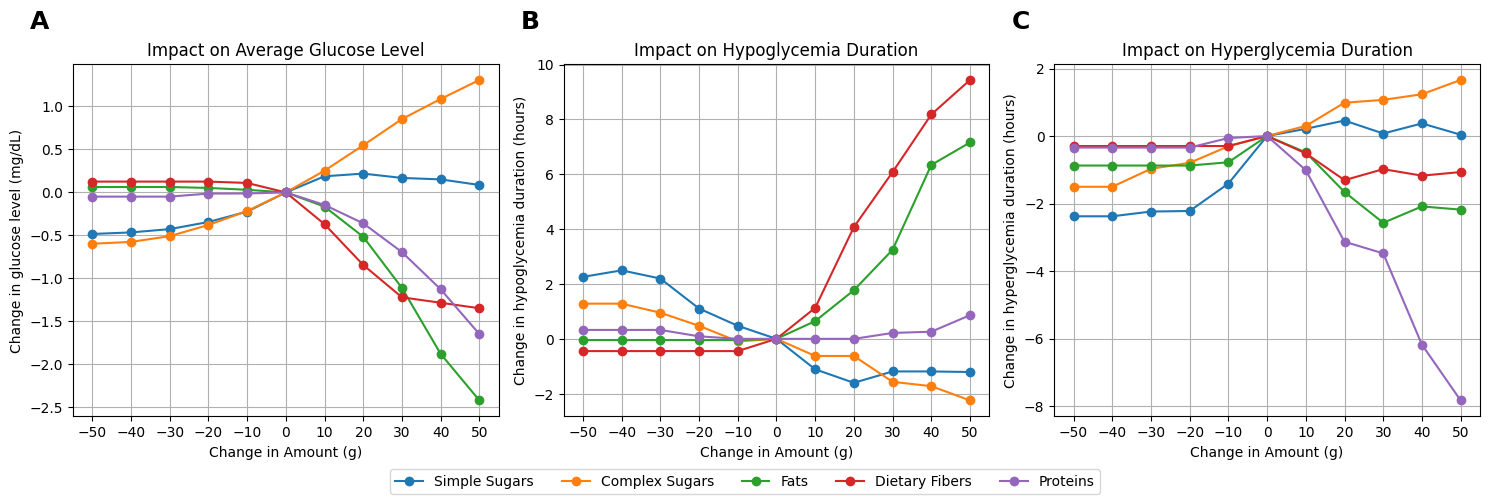

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Add bold A, B and C labels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=18, fontweight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=18, fontweight='bold')

# Plot hyperglycemia
for feature in meal_features:
    ax1.plot(
        glucose_difference_df['increment'],
        glucose_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax1.set_xlabel('Change in Amount (g)')
ax1.set_ylabel('Change in glucose level (mg/dL)')
ax1.set_title('Impact on Average Glucose Level')

ax1.grid(True)
ax1.set_xticks(increments)

# Plot hypoglycemia
for feature in meal_features:
    ax2.plot(
        hypo_difference_df['increment'],
        hypo_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax2.set_xlabel('Change in Amount (g)')
ax2.set_ylabel('Change in hypoglycemia duration (hours)')
ax2.set_title('Impact on Hypoglycemia Duration')
ax2.grid(True)
ax2.set_xticks(increments)

# Plot mean glucose changes
for feature in meal_features:
    ax3.plot(
        hyper_difference_df['increment'],
        hyper_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax3.set_xlabel('Change in Amount (g)')
ax3.set_title('Impact on Hyperglycemia Duration')
ax3.set_ylabel('Change in hyperglycemia duration (hours)')
ax3.grid(True)
ax3.set_xticks(increments)

# Add single legend at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(meal_features))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig('paper_images/nutrient_glycemia_difference.eps', format='eps')
plt.show()

## Glucovision

In [72]:
def modify_macronutrients(food_data, nutrient, amount, meal_time):
    modified_food_data = food_data.copy()
    # Find the meal closest to the specified meal_time
    time_diffs = abs(modified_food_data['datetime'] - meal_time)
    meal_index = time_diffs.idxmin()
    # Modify the nutrient for that meal
    modified_food_data.loc[meal_index, nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [112]:
patient = '007'
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")

In [138]:
# Initialize variables to track the best combination
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
meal_time = food_data['datetime'].iloc[4]

meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-20, -10, 0] # Changed to focus on reducing nutrients

# Load model once instead of in the loop
model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

# Get baseline prediction
data_baseline = get_data(patient, food_data, prediction_horizon)
test_baseline = add_features(feature_params, features, data_baseline, prediction_horizon, patient)

# Get timestamps within 30 minutes after meal
time_diffs = test_baseline['datetime'] - meal_time
valid_times = (time_diffs >= pd.Timedelta(minutes=0)) & (time_diffs <= pd.Timedelta(minutes=30))

if any(valid_times):
    prediction_index = test_baseline[valid_times].index[-1]
    X_test_baseline = test_baseline.drop(features_to_remove, axis=1)
    preds_baseline = test_baseline['glucose'][prediction_index] - model.predict(pd.DataFrame(X_test_baseline.iloc[prediction_index]).T)
    baseline_glucose = preds_baseline.loc[prediction_index].values[0]
    print(f"Baseline predicted glucose: {baseline_glucose:.2f} mg/dL")

Baseline predicted glucose: 174.66 mg/dL


In [140]:


best_prediction = baseline_glucose # Initialize to baseline instead of infinity
best_combination = {}

# Pre-calculate all possible combinations
combinations = list(itertools.product(increments, repeat=len(meal_features)))

# Pre-calculate time differences and valid indices
time_diffs = abs(food_data['datetime'] - meal_time)
meal_index = time_diffs.idxmin()

# Try all combinations in a vectorized way
for combo in combinations:
    # Create modifications dict
    modifications = dict(zip(meal_features, combo))
    
    # Start with original food data and apply modifications
    modified_food_data = food_data.copy()
    for nutrient, amount in modifications.items():
        modified_food_data.loc[meal_index, nutrient] = max(0, modified_food_data.loc[meal_index, nutrient] + amount)
    
    # Process modified data
    data_modified = get_data(patient, modified_food_data, prediction_horizon)
    test_modified = add_features(feature_params, features, data_modified, prediction_horizon, patient)
    
    # Use pre-calculated valid times window
    time_window = (test_modified['datetime'] >= meal_time) & (test_modified['datetime'] <= meal_time + pd.Timedelta(minutes=30))
    
    if not any(time_window):
        continue
        
    prediction_index = test_modified[time_window].index[-1]
    X_test_modified = test_modified.drop(features_to_remove, axis=1)
    
    # Get prediction
    predicted_glucose = test_modified['glucose'].iloc[prediction_index] - model.predict(pd.DataFrame(X_test_modified.iloc[prediction_index]).T)[0]
    
    
    # Update best only if prediction is LOWER than current best
    if predicted_glucose < best_prediction:
        best_prediction = predicted_glucose
        best_combination = modifications.copy()

print("\nBest combination found:")
for feature, amount in best_combination.items():
    print(f"{feature}: {amount}g change")
print(f"Resulting predicted glucose: {best_prediction:.2f} mg/dL")
print(f"Glucose reduction: {baseline_glucose - best_prediction:.2f} mg/dL")



Best combination found:
Resulting predicted glucose: 174.66 mg/dL
Glucose reduction: 0.00 mg/dL
